# **Dataset**

Dataset: [Populer Video Games - Kaggle](https://www.kaggle.com/datasets/matheusfonsecachaves/popular-video-games)

I used this data on July 14, 2023

# **Description**

Game rating prediction: Using attributes such as "Rating" as well as other features such as "Title", "Developers", "Summary", "Platforms", and "Genres," using NLP

# **Data Preparation**

## Library Imports

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

import pandas as pd
import tensorflow as tf
import nltk, os, re, string

import matplotlib.pyplot as plt

## Fetching & Exploring Dataset

In [93]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Belajar Pengembangan Machine Learning/backloggd_games.csv')
df.head()

,Unnamed: 0,Title,Release_Date,Developers,Summary,Platforms,Genres,Rating,Plays,Playing,Backlogs,Wishlist,Lists,Reviews
0,0,Elden Ring,"Feb 25, 2022","['FromSoftware', 'Bandai Namco Entertainment']","Elden Ring is a fantasy, action and open world...","['Windows PC', 'PlayStation 4', 'Xbox One', 'P...","['Adventure', 'RPG']",4.5,21K,4.1K,5.6K,5.5K,4.6K,3K
1,1,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",The Legend of Zelda: Breath of the Wild is the...,"['Wii U', 'Nintendo Switch']","['Adventure', 'Puzzle']",4.4,35K,3.1K,5.6K,3K,5.1K,3K
2,2,Hades,"Dec 07, 2018",['Supergiant Games'],A rogue-lite hack and slash dungeon crawler in...,"['Windows PC', 'Mac', 'PlayStation 4', 'Xbox O...","['Adventure', 'Brawler', 'Indie', 'RPG']",4.3,25K,3.5K,7.3K,4K,3.2K,2.1K
3,3,Hollow Knight,"Feb 24, 2017",['Team Cherry'],A 2D metroidvania with an emphasis on close co...,"['Windows PC', 'Mac', 'Linux', 'Nintendo Switch']","['Adventure', 'Indie', 'Platform']",4.4,25K,2.7K,9.6K,2.6K,3.4K,2.1K
4,4,Undertale,"Sep 15, 2015","['tobyfox', '8-4']","A small child falls into the Underground, wher...","['Windows PC', 'Mac', 'Linux', 'PlayStation 4'...","['Adventure', 'Indie', 'RPG', 'Turn Based Stra...",4.2,32K,728,5.7K,2.1K,3.9K,2.5K


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    60000 non-null  int64  
 1   Title         60000 non-null  object 
 2   Release_Date  60000 non-null  object 
 3   Developers    60000 non-null  object 
 4   Summary       55046 non-null  object 
 5   Platforms     60000 non-null  object 
 6   Genres        60000 non-null  object 
 7   Rating        25405 non-null  float64
 8   Plays         60000 non-null  object 
 9   Playing       60000 non-null  object 
 10  Backlogs      60000 non-null  object 
 11  Wishlist      60000 non-null  object 
 12  Lists         60000 non-null  object 
 13  Reviews       60000 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 6.4+ MB


In [95]:
df.shape

(60000, 14)

In [96]:
df.Rating.value_counts()

3.2    1624
3.3    1461
3.0    1415
2.8    1387
3.5    1362
3.4    1359
3.1    1342
3.6    1219
2.9    1105
3.7    1066
3.8     977
2.6     975
2.7     928
2.5     914
2.4     812
4.0     700
3.9     678
2.2     673
2.3     617
2.0     484
4.1     465
4.2     457
2.1     436
1.8     426
1.9     340
4.3     292
1.7     249
1.5     246
1.6     239
4.4     180
1.2     152
1.3     132
1.4     117
4.5     105
1.0      82
4.6      67
4.7      60
1.1      52
4.8      45
0.8      39
0.7      35
0.9      35
5.0      18
0.5      17
0.6      15
4.9       4
0.3       2
Name: Rating, dtype: int64

In [97]:
df.Genres.value_counts()

[]                                                                                                                   6741
['Adventure']                                                                                                        2925
['Shooter']                                                                                                          2415
['Adventure', 'Indie']                                                                                               2248
['Indie']                                                                                                            1972
                                                                                                                     ... 
['Indie', 'Pinball', 'Simulator']                                                                                       1
['Brawler', 'Fighting', 'Strategy']                                                                                     1
['Sport', 'Tactical']   

# **Preprocessing Text**

Remove useless features

In [98]:
cols_to_drop = ['Unnamed: 0', 'Release_Date',
                'Plays', 'Playing',
                'Backlogs', 'Wishlist',
                'Lists', 'Reviews']

In [99]:
df_new = df.drop(cols_to_drop, axis=1)

In [100]:
df_new.head()

,Title,Developers,Summary,Platforms,Genres,Rating
0,Elden Ring,"['FromSoftware', 'Bandai Namco Entertainment']","Elden Ring is a fantasy, action and open world...","['Windows PC', 'PlayStation 4', 'Xbox One', 'P...","['Adventure', 'RPG']",4.5
1,The Legend of Zelda: Breath of the Wild,"['Nintendo', 'Nintendo EPD Production Group No...",The Legend of Zelda: Breath of the Wild is the...,"['Wii U', 'Nintendo Switch']","['Adventure', 'Puzzle']",4.4
2,Hades,['Supergiant Games'],A rogue-lite hack and slash dungeon crawler in...,"['Windows PC', 'Mac', 'PlayStation 4', 'Xbox O...","['Adventure', 'Brawler', 'Indie', 'RPG']",4.3
3,Hollow Knight,['Team Cherry'],A 2D metroidvania with an emphasis on close co...,"['Windows PC', 'Mac', 'Linux', 'Nintendo Switch']","['Adventure', 'Indie', 'Platform']",4.4
4,Undertale,"['tobyfox', '8-4']","A small child falls into the Underground, wher...","['Windows PC', 'Mac', 'Linux', 'PlayStation 4'...","['Adventure', 'Indie', 'RPG', 'Turn Based Stra...",4.2


In [101]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Title       60000 non-null  object 
 1   Developers  60000 non-null  object 
 2   Summary     55046 non-null  object 
 3   Platforms   60000 non-null  object 
 4   Genres      60000 non-null  object 
 5   Rating      25405 non-null  float64
dtypes: float64(1), object(5)
memory usage: 2.7+ MB


From the data.info() output, the Summary column has 55,046 non-null values and the Rating column has 25,405 non-null values, while the other columns (Title, Developers, Platforms, and Genres) all have 60,000 non-null values

In [102]:
df_new.sample(3)

,Title,Developers,Summary,Platforms,Genres,Rating
29504,Space Pilgrim Academy: Year 1,"['Pilgrim Adventures', 'GrabTheGames']",Latona Research Station has been destroyed by ...,['Windows PC'],"['Adventure', 'Indie']",NaN
12956,Goal FH,[],NaN,['3DO Interactive Multiplayer'],[],NaN
58896,Battleborn: Attikus and the Thrall Rebellion,[],NaN,['PlayStation 4'],[],NaN


In [103]:
df_new.Summary

0        Elden Ring is a fantasy, action and open world...
1        The Legend of Zelda: Breath of the Wild is the...
2        A rogue-lite hack and slash dungeon crawler in...
3        A 2D metroidvania with an emphasis on close co...
4        A small child falls into the Underground, wher...
                               ...                        
59995    While constantly working on a video game witho...
59996    The Definitive Edition will have all of the DL...
59997    Years after the events of "Wraith", a young gi...
59998    While constantly working on a video game witho...
59999    The Definitive Edition will have all of the DL...
Name: Summary, Length: 60000, dtype: object

## Download wordnet dan stopwords

In [104]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Lower-case all characters

In [105]:
df_new.Title = df_new.Title.apply(lambda x: x.lower())
df_new.Developers = df_new.Developers.apply(lambda x: x.lower())
df_new.Summary = df_new.Summary.fillna('').apply(lambda x: x.lower())
df_new.Platforms = df_new.Platforms.apply(lambda x: x.lower())
df_new.Genres = df_new.Genres.apply(lambda x: x.lower())

## Delete functions

In [106]:
def cleaner(data):
    return(data.translate(str.maketrans('','', string.punctuation)))
    df_new.Title = df_new.Title.apply(lambda x: cleaner(x))
    df_new.Developers = df_new.Developers.apply(lambda x: lem(x))
    df_new.Summary = df_new.Summary.apply(lambda x: lem(x))
    df_new.Platforms = df_new.Platforms.apply(lambda x: lem(x))
    df_new.Genres = df_new.Genres.apply(lambda x: lem(x))

## Lematization

In [107]:
lemmatizer = WordNetLemmatizer()
def lem(data):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(data.split())]))
    df_new.Title = df_new.Title.apply(lambda x: lem(x))
    df_new.Developers = df_new.Developers.apply(lambda x: lem(x))
    df_new.Summary = df_new.Summary.apply(lambda x: lem(x))
    df_new.Platforms = df_new.Platforms.apply(lambda x: lem(x))
    df_new.Genres = df_new.Genres.apply(lambda x: lem(x))

## Delete Numbers

In [108]:
def rem_numbers(data):
    return re.sub('[0-9]+','',data)
    df_new['Title'].apply(rem_numbers)
    df_new['Developers'].apply(rem_numbers)
    df_new['Summary'].apply(rem_numbers)
    df_new['Platforms'].apply(rem_numbers)
    df_new['Genres'].apply(rem_numbers)

## Delete Stopword

In [109]:
st_words = stopwords.words()
def stopword(data):
    return(' '.join([w for w in data.split() if w not in st_words ]))
    df_new.Title = df_new.Title.apply(lambda x: stopword(x))
    df_new.Developers = df_new.Developers.apply(lambda x: lem(x))
    df_new.Summary = df_new.Summary.apply(lambda x: lem(x))
    df_new.Platforms = df_new.Platforms.apply(lambda x: lem(x))
    df_new.Genres = df_new.Genres.apply(lambda x: lem(x))

### **Summary column**

Nilai NaN pada kolom atau baris relatif besar, maka untuk mengisi missing values dengan angka atau strategy akan lebih tepat dengan menggunakan 'most_frequent' (nilai yang paling sering muncul)

In [110]:
imputer = SimpleImputer(strategy='most_frequent')
target = df_new['Summary']
features = df_new.drop('Summary', axis=1)

# Melakukan imputasi pada dataset features
features_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)
df_imputed = pd.concat([features_imputed, target], axis=1)

In [111]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Title       60000 non-null  object
 1   Developers  60000 non-null  object
 2   Platforms   60000 non-null  object
 3   Genres      60000 non-null  object
 4   Rating      60000 non-null  object
 5   Summary     60000 non-null  object
dtypes: object(6)
memory usage: 2.7+ MB


### **Rating column**

In [112]:
imputer = SimpleImputer(strategy='most_frequent')
target = df_imputed['Rating']
features = df_imputed.drop('Rating', axis=1)

features_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)
df_final = pd.concat([features_imputed, target], axis=1)

# df_final = data.dropna(subset=['Summary'])
# df_final = data.dropna(subset=['Rating'])

In [113]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Title       60000 non-null  object
 1   Developers  60000 non-null  object
 2   Platforms   60000 non-null  object
 3   Genres      60000 non-null  object
 4   Summary     60000 non-null  object
 5   Rating      60000 non-null  object
dtypes: object(6)
memory usage: 2.7+ MB


In [114]:
df_final.sample(5)

,Title,Developers,Platforms,Genres,Summary,Rating
24961,grimshade,"['asterion games', 'talerock']","['windows pc', 'nintendo switch']","['adventure', 'indie', 'rpg', 'strategy', 'tac...",grimshade is a story-driven tactical rpg featu...,3.2
31670,rolando the majestic,[],['windows pc'],"['adventure', 'indie']",become rolando the majestic and find out how h...,3.2
38969,treasure of abyss,['han xu'],['windows pc'],"['adventure', 'indie', 'rpg']",,3.2
27652,fantasy life online,['level-5'],"['android', 'ios']","['adventure', 'rpg', 'simulator']",a sequel to the nintendo 3ds life-sim/rpg this...,2.1
55126,aah little atlantis,[],[],[],,3.2


In [115]:
df_final.Rating

0        4.5
1        4.4
2        4.3
3        4.4
4        4.2
        ... 
59995    3.2
59996    3.7
59997    3.2
59998    3.2
59999    3.7
Name: Rating, Length: 60000, dtype: object

Create 'positive', 'neutral' and 'negative' columns/labels based on Rating conditions

In [116]:
df_final['label_rating'] = df_final['Rating'].apply(
    lambda x: ('positive' if x >= 4 else ('neutral' if x >= 3 else 'negative'))
)

In [117]:
df_final.label_rating

0        positive
1        positive
2        positive
3        positive
4        positive
           ...   
59995     neutral
59996     neutral
59997     neutral
59998     neutral
59999     neutral
Name: label_rating, Length: 60000, dtype: object

In [118]:
df_final.loc[df_final['label_rating'] == 'positive']

,Title,Developers,Platforms,Genres,Summary,Rating,label_rating
0,elden ring,"['fromsoftware', 'bandai namco entertainment']","['windows pc', 'playstation 4', 'xbox one', 'p...","['adventure', 'rpg']","elden ring is a fantasy, action and open world...",4.5,positive
1,the legend of zelda: breath of the wild,"['nintendo', 'nintendo epd production group no...","['wii u', 'nintendo switch']","['adventure', 'puzzle']",the legend of zelda: breath of the wild is the...,4.4,positive
2,hades,['supergiant games'],"['windows pc', 'mac', 'playstation 4', 'xbox o...","['adventure', 'brawler', 'indie', 'rpg']",a rogue-lite hack and slash dungeon crawler in...,4.3,positive
3,hollow knight,['team cherry'],"['windows pc', 'mac', 'linux', 'nintendo switch']","['adventure', 'indie', 'platform']",a 2d metroidvania with an emphasis on close co...,4.4,positive
4,undertale,"['tobyfox', '8-4']","['windows pc', 'mac', 'linux', 'playstation 4'...","['adventure', 'indie', 'rpg', 'turn based stra...","a small child falls into the underground, wher...",4.2,positive
...,...,...,...,...,...,...,...
59800,the king of fighters '98 ultimate match final ...,['snk playmore'],"['windows pc', 'playstation 4', 'arcade']","['arcade', 'fighting', 'rpg']","after kof '98, often praised by the fans as th...",4.2,positive
59830,boku no natsuyasumi 3: kitaguni-hen - chiisana...,"['sony computer entertainment, inc. (scei)', '...",['playstation 3'],['adventure'],,4.2,positive
59871,rescue: the beagles,['nenad jalsovec'],['windows pc'],['platform'],independently developed 2d platformer for pcs.,4.0,positive
59876,segare ijiri,['enix'],['playstation'],"['adventure', 'platform']","in segare ijiri, the player takes control of a...",4.0,positive


In [119]:
df_final.loc[df_final['label_rating'] == 'neutral']

,Title,Developers,Platforms,Genres,Summary,Rating,label_rating
11,among us,['innersloth'],"['windows pc', 'android', 'playstation 4', 'io...","['indie', 'strategy']",play with 4-15 player online or via local wifi...,3.0,neutral
18,stray,"['annapurna interactive', 'bluetwelve studio']","['windows pc', 'mac', 'playstation 4', 'playst...","['adventure', 'indie']","lost, alone, and separated from family, a stra...",3.7,neutral
23,grand theft auto v,"['rockstar north', 'rockstar games']","['windows pc', 'xbox 360', 'playstation 4', 'p...","['adventure', 'shooter']",grand theft auto v is a vast open world game s...,3.8,neutral
25,cyberpunk 2077,['cd projekt red'],"['windows pc', 'playstation 4', 'xbox one', 'p...","['adventure', 'rpg', 'shooter']","cyberpunk 2077 is an open-world, action-advent...",3.4,neutral
27,pokémon legends: arceus,"['nintendo', 'game freak']",['nintendo switch'],"['adventure', 'rpg', 'turn based strategy']",the pokémon legends: arceus game honors past p...,3.7,neutral
...,...,...,...,...,...,...,...
59995,dragon spirits,"['fhnbhj', 'indienova']",['windows pc'],['rpg'],while constantly working on a video game witho...,3.2,neutral
59996,pathfinder: kingmaker - definitive edition,"['owlcat games', 'deep silver']","['playstation 4', 'xbox one']","['rpg', 'tactical']",the definitive edition will have all of the dl...,3.7,neutral
59997,sainth,['neo kuriyo'],['windows pc'],[],"years after the events of ""wraith"", a young gi...",3.2,neutral
59998,dragon spirits,"['fhnbhj', 'indienova']",['windows pc'],['rpg'],while constantly working on a video game witho...,3.2,neutral


In [120]:
df_final.loc[df_final['label_rating'] == 'negative']

,Title,Developers,Platforms,Genres,Summary,Rating,label_rating
41,genshin impact,"['mihoyo', 'hoyoverse']","['windows pc', 'android', 'playstation 4', 'io...","['adventure', 'rpg']","genshin impact is an open-world action rpg, wh...",2.6,negative
59,overwatch 2,['blizzard entertainment'],"['windows pc', 'playstation 4', 'xbox one', 'p...",['shooter'],reunite and stand together in a new age of her...,2.6,negative
64,fortnite,['epic games'],"['windows pc', 'android', 'mac', 'playstation ...","['adventure', 'rpg', 'shooter', 'strategy']",fortnite is the completely free online game wh...,2.8,negative
115,league of legends,"['goa games services ltd.', 'riot games']","['windows pc', 'mac']","['moba', 'rpg', 'strategy']","league of legends is a fast-paced, competitive...",2.1,negative
122,multiversus,"['player first games', 'wb games']","['windows pc', 'playstation 4', 'xbox one', 'p...",['fighting'],multiversus is a platform fighter that lets yo...,2.7,negative
...,...,...,...,...,...,...,...
59961,loot hero dx,"['varagtp', 'ratalaika games s.l.']","['windows pc', 'playstation 4', 'xbox one', 'n...","['adventure', 'arcade', 'indie', 'rpg']",a legendary dragon is haunting the lands. town...,2.0,negative
59962,iron harvest,"['king art games', 'king art']","['windows pc', 'playstation 4', 'xbox one']","['real time strategy', 'strategy']",after world war 1 farmers found a plethora of ...,2.8,negative
59973,fifa manager 14,"['bright future', 'electronic arts']",['windows pc'],['sport'],fifa manager 14: legacy edition is a re-releas...,2.5,negative
59978,super widget,[],['snes'],['platform'],planet earth is in danger from assorted villai...,2.7,negative


In [121]:
df_final = df_final.drop('Rating', axis=1)
df_final.head(2)

,Title,Developers,Platforms,Genres,Summary,label_rating
0,elden ring,"['fromsoftware', 'bandai namco entertainment']","['windows pc', 'playstation 4', 'xbox one', 'p...","['adventure', 'rpg']","elden ring is a fantasy, action and open world...",positive
1,the legend of zelda: breath of the wild,"['nintendo', 'nintendo epd production group no...","['wii u', 'nintendo switch']","['adventure', 'puzzle']",the legend of zelda: breath of the wild is the...,positive


# **Feature Extraction**

Performs a one-hot-encoding process

In [122]:
category = pd.get_dummies(df_final.label_rating)
df_new_final = pd.concat([df_final, category], axis=1)
df_new_final = df_new_final.drop(columns='label_rating')
df_new_final.head(3)

,Title,Developers,Platforms,Genres,Summary,negative,neutral,positive
0,elden ring,"['fromsoftware', 'bandai namco entertainment']","['windows pc', 'playstation 4', 'xbox one', 'p...","['adventure', 'rpg']","elden ring is a fantasy, action and open world...",0,0,1
1,the legend of zelda: breath of the wild,"['nintendo', 'nintendo epd production group no...","['wii u', 'nintendo switch']","['adventure', 'puzzle']",the legend of zelda: breath of the wild is the...,0,0,1
2,hades,['supergiant games'],"['windows pc', 'mac', 'playstation 4', 'xbox o...","['adventure', 'brawler', 'indie', 'rpg']",a rogue-lite hack and slash dungeon crawler in...,0,0,1


In [123]:
df_new_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Title       60000 non-null  object
 1   Developers  60000 non-null  object
 2   Platforms   60000 non-null  object
 3   Genres      60000 non-null  object
 4   Summary     60000 non-null  object
 5   negative    60000 non-null  uint8 
 6   neutral     60000 non-null  uint8 
 7   positive    60000 non-null  uint8 
dtypes: object(5), uint8(3)
memory usage: 2.5+ MB


In [124]:
combined_atribut = df_new_final['Title'].values + '' + df_new_final['Developers'].values+ '' + df_new_final['Platforms'].values	+ '' + df_new_final['Genres'].values + '' + df_new_final['Summary'].values
combined_atribut

array(["elden ring['fromsoftware', 'bandai namco entertainment']['windows pc', 'playstation 4', 'xbox one', 'playstation 5', 'xbox series']['adventure', 'rpg']elden ring is a fantasy, action and open world game with rpg elements such as stats, weapons and spells. rise, tarnished, and be guided by grace to brandish the power of the elden ring and become an elden lord in the lands between.",
       "the legend of zelda: breath of the wild['nintendo', 'nintendo epd production group no. 3']['wii u', 'nintendo switch']['adventure', 'puzzle']the legend of zelda: breath of the wild is the first 3d open-world game in the zelda series. link can travel anywhere and be equipped with weapons and armor found throughout the world to grant him various bonuses. unlike many games in the series, breath of the wild does not impose a specific order in which quests or dungeons must be completed. while the game still has environmental obstacles such as weather effects, inhospitable lands, or powerful enemie

In [125]:
# Selects all rows and takes columns starting from the 5th index to the end
label = df_new_final.iloc[:, 5:]
label

,negative,neutral,positive
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
59995,0,1,0
59996,0,1,0
59997,0,1,0
59998,0,1,0


In [126]:
# Converts the result to a numpy array
label.values

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=uint8)

# **Building a Classification Model**

Dividing data for training and data for testing

In [127]:
atribut_latih, atribut_test, label_latih, label_test = train_test_split(
      combined_atribut, label, shuffle=True, test_size=0.2
    )

print('Total atribut_latih:', len(atribut_latih))
print('Total atribut_test:', len(atribut_test))

Total atribut_latih: 48000
Total atribut_test: 12000


*   Turning every word in our dataset into a numeric number with the Tokenizer function
*   Then convert each sample to sequence



In [128]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(atribut_latih)
# tokenizer.fit_on_texts(atribut_test)

sekuens_latih = tokenizer.texts_to_sequences(atribut_latih)
sekuens_test = tokenizer.texts_to_sequences(atribut_test)

padding_latih = pad_sequences(sekuens_latih)
padding_test = pad_sequences(sekuens_test)

In [129]:
maxlen = max(len(sequence) for sequence in sekuens_latih + sekuens_test)
print("Panjang maksimum: ", maxlen)

# padding_latih = pad_sequences(sekuens_latih, padding='post',
#                               maxlen=maxlen, truncating='post')
# padding_test = pad_sequences(sekuens_latih, padding='post',
#                              maxlen=maxlen, truncating='post')

Panjang maksimum:  1559


# **Model Evaluation**

In [130]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    # Menggunakan Bidirectional LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          80000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              41472     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 1024)              132096    
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                      

## Callback

In [131]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      self.model.stop_training = True
      print('\n\nCallback called --- Done training!')
      print(" Accuracy above 90% ".center(33, '-'), '\n\n')
callbacks = myCallback()

## Models Training

In [135]:
%%time
history = model.fit(
    padding_latih,
    label_latih,
    epochs=50,
    validation_data=(padding_test, label_test),
    verbose=2,
    batch_size=256,
    shuffle=True,
    validation_steps=30,
    callbacks=[callbacks]
)

Epoch 1/50
188/188 - 35s - loss: 0.5384 - accuracy: 0.7862 - val_loss: 0.5478 - val_accuracy: 0.7940 - 35s/epoch - 188ms/step
Epoch 2/50
188/188 - 29s - loss: 0.4966 - accuracy: 0.8033 - val_loss: 0.5489 - val_accuracy: 0.7949 - 29s/epoch - 156ms/step
Epoch 3/50
188/188 - 28s - loss: 0.4623 - accuracy: 0.8198 - val_loss: 0.5505 - val_accuracy: 0.7935 - 28s/epoch - 148ms/step
Epoch 4/50
188/188 - 28s - loss: 0.4350 - accuracy: 0.8340 - val_loss: 0.5765 - val_accuracy: 0.7965 - 28s/epoch - 147ms/step
Epoch 5/50
188/188 - 27s - loss: 0.4064 - accuracy: 0.8476 - val_loss: 0.6007 - val_accuracy: 0.7880 - 27s/epoch - 142ms/step
Epoch 6/50
188/188 - 26s - loss: 0.3816 - accuracy: 0.8594 - val_loss: 0.6389 - val_accuracy: 0.7754 - 26s/epoch - 140ms/step
Epoch 7/50
188/188 - 26s - loss: 0.3576 - accuracy: 0.8700 - val_loss: 0.6639 - val_accuracy: 0.7845 - 26s/epoch - 139ms/step
Epoch 8/50
188/188 - 26s - loss: 0.3343 - accuracy: 0.8801 - val_loss: 0.6871 - val_accuracy: 0.7893 - 26s/epoch - 136

## Accuracy Graph

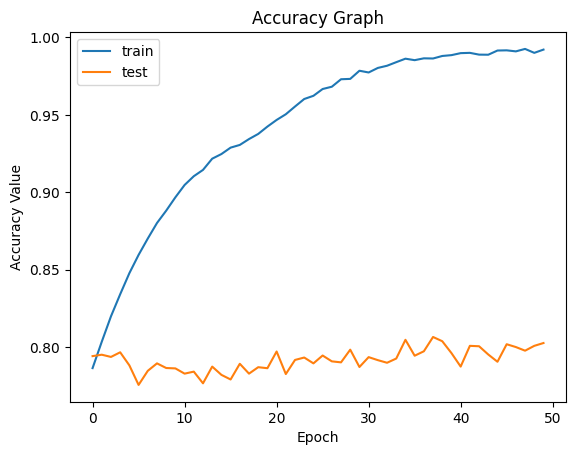

In [136]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Graph')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Loss Graph

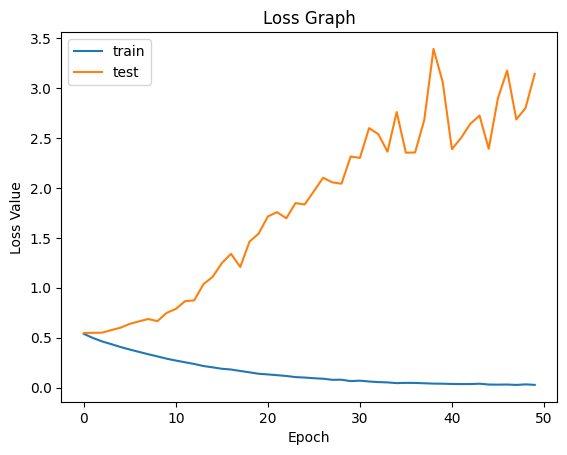

In [137]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Graph')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()